# Assignment 11: Truncated SVD

<h2>Data splitting and pre-processing</h2>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


import pickle
from tqdm import tqdm
import os
from collections import Counter



In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
project_data.isnull().sum()

Unnamed: 0                                           0
id                                                   0
teacher_id                                           0
teacher_prefix                                       3
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105490
project_essay_4                                 105490
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64

In [4]:
#filling 3 null teacher prefix values with Teacher

project_data["teacher_prefix"].fillna("Teacher",inplace = True)
project_data.isnull().sum()

Unnamed: 0                                           0
id                                                   0
teacher_id                                           0
teacher_prefix                                       0
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105490
project_essay_4                                 105490
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64

In [5]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [6]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [7]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109248 entries, 0 to 109247
Data columns (total 20 columns):
Unnamed: 0                                      109248 non-null int64
id                                              109248 non-null object
teacher_id                                      109248 non-null object
teacher_prefix                                  109248 non-null object
school_state                                    109248 non-null object
project_submitted_datetime                      109248 non-null object
project_grade_category                          109248 non-null object
project_subject_categories                      109248 non-null object
project_subject_subcategories                   109248 non-null object
project_title                                   109248 non-null object
project_essay_1                                 109248 non-null object
project_essay_2                                 109248 non-null object
project_essay_3                       

**Considering only 20k train , 5k validation and 5k test data points**

In [8]:
from sklearn.utils import resample
p_d = resample(project_data,n_samples = 20000)

In [9]:
#splitting data as 30% to test
y = p_d["project_is_approved"]
X = p_d.drop("project_is_approved",axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [10]:
print(X_train.shape," ",y_train.shape)
print(X_test.shape," ",y_test.shape)
print(X_val.shape," ",y_val.shape)

(10050, 19)   (10050,)
(5000, 19)   (5000,)
(4950, 19)   (4950,)


<h3>Preprocessing categorical Features</h3>

1. project subject categories

In [11]:
#using code from assignment
# project subject categories
catogories = list(X_train['project_subject_categories'].values)

cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_') 
    cat_list.append(temp.strip())
    
X_train['clean_categories'] = cat_list
X_train.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in X_train['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


# project subject categories for test data

catogories = list(X_test['project_subject_categories'].values)

cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_') 
    cat_list.append(temp.strip())
    
X_test['clean_categories'] = cat_list
X_test.drop(['project_subject_categories'], axis=1, inplace=True)

# project subject categories for test data

catogories = list(X_val['project_subject_categories'].values)

cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_') 
    cat_list.append(temp.strip())
    
X_val['clean_categories'] = cat_list
X_val.drop(['project_subject_categories'], axis=1, inplace=True)


2. project subject sub_categories

In [12]:
sub_catogories = list(X_train['project_subject_subcategories'].values)
sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') 
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

X_train['clean_subcategories'] = sub_cat_list
X_train.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in X_train['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


sub_catogories = list(X_test['project_subject_subcategories'].values)
sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') 
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

X_test['clean_subcategories'] = sub_cat_list
X_test.drop(['project_subject_subcategories'], axis=1, inplace=True)


# for validation data set
sub_catogories = list(X_val['project_subject_subcategories'].values)
sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') 
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

X_val['clean_subcategories'] = sub_cat_list
X_val.drop(['project_subject_subcategories'], axis=1, inplace=True)

3. Teacher Prefix

In [13]:
#preprocessing teacher prefix
prefix = list(X_train['teacher_prefix'].values)
prefix_list = []
for i in prefix:
    temp = ""
    if "." in i: 
            i=i.replace('.','') 
    temp+=i.strip()+" " 
    prefix_list.append(temp.strip())
    
X_train['clean_prefix'] = prefix_list

my_counter = Counter()
for word in X_train['clean_prefix'].values:
  my_counter.update(word.split())

prefix_dict = dict(my_counter)
sorted_prefix_dict = dict(sorted(prefix_dict.items(), key=lambda kv: kv[1]))
print(sorted_prefix_dict)


#preprocessing teacher prefix for test data
prefix = list(X_test['teacher_prefix'].values)
prefix_list = []
for i in prefix:
    temp = ""
    if "." in i: 
            i=i.replace('.','') 
    temp+=i.strip()+" " 
    prefix_list.append(temp.strip())
    
X_test['clean_prefix'] = prefix_list

#preprocessing teacher prefix for val data
prefix = list(X_val['teacher_prefix'].values)
prefix_list = []
for i in prefix:
    temp = ""
    if "." in i: 
            i=i.replace('.','') 
    temp+=i.strip()+" " 
    prefix_list.append(temp.strip())
    
X_val['clean_prefix'] = prefix_list

{'Dr': 1, 'Teacher': 227, 'Mr': 994, 'Ms': 3532, 'Mrs': 5296}


4. Project Grade Category

In [14]:
# preprocessing of grade category for train data

grade = list(X_train['project_grade_category'].values)
grade_list = []
for i in grade:
    temp = ""
    if "Grades" in i:
      i = i.replace("Grades","")
    if "6-8" in i:
      i = i.replace("6-8","six_eight")
    if "3-5" in i:
      i = i.replace("3-5","three_five")
    if "9-12" in i:
      i = i.replace("9-12","nine_twelve")
    if "PreK-2" in i:
      i = i.replace("PreK-2","prek_two")
    temp+=i.strip()+" " 
    grade_list.append(temp.strip())
    
X_train['clean_grade'] = grade_list

my_counter = Counter()
for word in X_train['clean_grade'].values:
  my_counter.update(word.split())

grade_dict = dict(my_counter)
sorted_grade_dict = dict(sorted(grade_dict.items(), key=lambda kv: kv[1]))
print(sorted_grade_dict)

# preprocessing of grade category for test data

grade = list(X_test['project_grade_category'].values)
grade_list = []
for i in grade:
    temp = ""
    if "Grades" in i:
      i = i.replace("Grades","")
    if "6-8" in i:
      i = i.replace("6-8","six_eight")
    if "3-5" in i:
      i = i.replace("3-5","three_five")
    if "9-12" in i:
      i = i.replace("9-12","nine_twelve")
    if "PreK-2" in i:
      i = i.replace("PreK-2","prek_two")
    temp+=i.strip()+" " 
    grade_list.append(temp.strip())
    
X_test['clean_grade'] = grade_list


grade = list(X_val['project_grade_category'].values)
grade_list = []
for i in grade:
    temp = ""
    if "Grades" in i:
      i = i.replace("Grades","")
    if "6-8" in i:
      i = i.replace("6-8","six_eight")
    if "3-5" in i:
      i = i.replace("3-5","three_five")
    if "9-12" in i:
      i = i.replace("9-12","nine_twelve")
    if "PreK-2" in i:
      i = i.replace("PreK-2","prek_two")
    temp+=i.strip()+" " 
    grade_list.append(temp.strip())
    
X_val['clean_grade'] = grade_list


{'nine_twelve': 1039, 'six_eight': 1519, 'three_five': 3448, 'prek_two': 4044}


5. School State

In [15]:
#no need of preprocessing on school state

state = X_train["school_state"].value_counts()
sorted_state = dict(state)
sorted_state_dict = dict(sorted(sorted_state.items(), key=lambda kv: kv[1]))
X_train["clean_state"] = X_train["school_state"]

#similarly for X_test
X_test["clean_state"] = X_test["school_state"]

#similarly for X_val
X_val["clean_state"] = X_val["school_state"]

<h3>Preprocessing Numerical Feature</h3>

1. Standardizing price

In [16]:
from sklearn.preprocessing import StandardScaler


price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) 
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

#train data price standardization
price_standardized = price_scalar.transform(X_train['price'].values.reshape(-1, 1))

#val data price stanardization. Fit method applied on X_train
val_price_standardized = price_scalar.transform(X_val['price'].values.reshape(-1, 1))


#test data price stanardization. Fit method applied on X_train
test_price_standardized = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


2. Standardizing quantity

In [17]:
warnings.filterwarnings("ignore")
price_scalar = StandardScaler()
price_scalar.fit(X_train["quantity"].values.reshape(-1, 1))
print(f"Mean of Quantity : {price_scalar.mean_[0]}, Standard deviation of Quantity : {np.sqrt(price_scalar.var_[0])}")

#train data quantity standardization
quantity_standardized = price_scalar.transform(X_train["quantity"].values.reshape(-1, 1))

#val data quantity stanardization. Fit method applied on X_train
val_quantity_standardized = price_scalar.transform(X_val["quantity"].values.reshape(-1, 1))

#test data quantity stanardization. Fit method applied on X_train
test_quantity_standardized = price_scalar.transform(X_test["quantity"].values.reshape(-1, 1))

Mean of Quantity : 16.577512437810945, Standard deviation of Quantity : 23.739154879840378


3. Standardizing number of ppp

In [18]:
price_scalar = StandardScaler()
price_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) 
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

#train data ppp standardization
number_ppp_standardized = price_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

#val data price stanardization. Fit method applied on X_train
val_number_ppp_standardized = price_scalar.transform(X_val['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

#test data price stanardization. Fit method applied on X_train
test_number_ppp_standardized = price_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 11.201691542288557, Standard deviation : 27.708748499478308


<h3>Preprocessing of Text Feature for both test and train data</h3>

In [19]:
#using function and stopwords form assignemnt

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
  
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

1. preprocessing of project essay

In [20]:
from tqdm import tqdm

#for train data
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

X_train["essay"] = preprocessed_essays
    
val_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_val['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    val_preprocessed_essays.append(sent.lower().strip())

X_val["essay"] = val_preprocessed_essays  
    
test_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    test_preprocessed_essays.append(sent.lower().strip())
    
X_test["essay"]  = test_preprocessed_essays

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1511.62it/s]


2. preprocessing of project title

In [21]:
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())
    
X_train["project_title"] = preprocessed_title  
    
# for val data
val_preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(X_val['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    val_preprocessed_title.append(sent.lower().strip())
    
X_val["project_title"] = val_preprocessed_title  


# for test data
test_preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    test_preprocessed_title.append(sent.lower().strip())

X_test["project_title"] = test_preprocessed_title  


100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 28173.67it/s]


In [22]:
# concatening project_essay + project_title

X_train["combine"] = X_train["essay"] + X_train["project_title"]
X_test["combine"] = X_test["essay"] + X_test["project_title"]
X_val["combine"] = X_val["essay"] + X_val["project_title"]

In [23]:
X_train["title_len"] = X_train["project_title"].apply(lambda x : len(x.split()))
X_test["title_len"] = X_test["project_title"].apply(lambda x : len(x.split()))
X_val["title_len"] = X_val["project_title"].apply(lambda x : len(x.split()))

<h3>Vectorizing of Categorical data</h3>

1. Vectorizing project categories and subcategories

In [24]:
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)

# fitting on train data
vectorizer.fit(X_train['clean_categories'].values)
print(vectorizer.get_feature_names())
categories_feature = vectorizer.get_feature_names()

# for train data
categories_one_hot = vectorizer.transform(X_train['clean_categories'].values)

print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

# for val data
val_categories_one_hot = vectorizer.transform(X_val['clean_categories'].values)


# for test data
test_categories_one_hot = vectorizer.transform(X_test['clean_categories'].values)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (10050, 9)


In [25]:
# printing one hot encoded array..
for i in range(3):
    print(test_categories_one_hot[i].toarray()[0]," ==> ",vectorizer.inverse_transform(test_categories_one_hot[i].toarray())[0])

[0 0 0 0 0 1 0 0 0]  ==>  ['SpecialNeeds']
[0 0 0 0 0 0 0 0 1]  ==>  ['Literacy_Language']
[0 0 0 0 1 1 0 0 0]  ==>  ['AppliedLearning' 'SpecialNeeds']


2. Vectorizing project subcategories

In [26]:
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)

# fitting on train data
vectorizer.fit(X_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())
subcategories_feature = vectorizer.get_feature_names()

# for train data
sub_categories_one_hot = vectorizer.transform(X_train['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

# for val data
val_sub_categories_one_hot = vectorizer.transform(X_val['clean_subcategories'].values)


# for test data
test_sub_categories_one_hot = vectorizer.transform(X_test['clean_subcategories'].values)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Civics_Government', 'Extracurricular', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'Other', 'College_CareerPrep', 'TeamSports', 'Music', 'History_Geography', 'Health_LifeScience', 'ESL', 'EarlyDevelopment', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (10050, 30)


In [27]:
# printing one hot encoded array..
for i in range(3):
    print(test_sub_categories_one_hot[i].toarray()[0]," ==> ",vectorizer.inverse_transform(test_sub_categories_one_hot[i].toarray())[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]  ==>  ['SpecialNeeds']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]  ==>  ['Literacy']
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]  ==>  ['CharacterEducation' 'SpecialNeeds']


3. vectorizing teacher prefix

In [28]:
vectorizer = CountVectorizer(vocabulary=list(prefix_dict.keys()), lowercase=False, binary=True)

# fitting on train data
vectorizer.fit(X_train['clean_prefix'].values)
print(vectorizer.get_feature_names())
prefix_feature = vectorizer.get_feature_names()
# for train data
prefix_one_hot = vectorizer.transform(X_train['clean_prefix'].values)
print("Shape of matrix after one hot encodig ",prefix_one_hot.shape)

# for val data
val_prefix_one_hot = vectorizer.transform(X_val['clean_prefix'].values)


# for test data
test_prefix_one_hot = vectorizer.transform(X_test['clean_prefix'].values)

['Mrs', 'Mr', 'Ms', 'Teacher', 'Dr']
Shape of matrix after one hot encodig  (10050, 5)


In [29]:
# printing one hot encoded array..
for i in range(3):
    print(test_prefix_one_hot[i].toarray()[0]," ==> ",vectorizer.inverse_transform(test_prefix_one_hot[i].toarray())[0])

[0 0 1 0 0]  ==>  ['Ms']
[0 0 1 0 0]  ==>  ['Ms']
[0 0 1 0 0]  ==>  ['Ms']


4. Vectorizing grade

In [30]:
vectorizer = CountVectorizer(vocabulary=list(grade_dict.keys()), lowercase=False, binary=True)

# fitting on train data
vectorizer.fit(X_train['clean_grade'].values)
print(vectorizer.get_feature_names())
grade_feature = vectorizer.get_feature_names()
# for train data
grade_one_hot = vectorizer.transform(X_train['clean_grade'].values)
print("Shape of matrix after one hot encodig ",grade_one_hot.shape)

# for val data
val_grade_one_hot = vectorizer.transform(X_val['clean_grade'].values)

# for test data
test_grade_one_hot = vectorizer.transform(X_test['clean_grade'].values)


['three_five', 'nine_twelve', 'prek_two', 'six_eight']
Shape of matrix after one hot encodig  (10050, 4)


In [31]:
# printing one hot encoded array..
for i in range(5):
    print(grade_one_hot[i].toarray()[0]," ==> ",vectorizer.inverse_transform(grade_one_hot[i].toarray())[0])

[1 0 0 0]  ==>  ['three_five']
[0 1 0 0]  ==>  ['nine_twelve']
[0 0 1 0]  ==>  ['prek_two']
[1 0 0 0]  ==>  ['three_five']
[0 0 1 0]  ==>  ['prek_two']


5. Vectorizing school state

In [32]:
vectorizer = CountVectorizer(vocabulary=list(sorted_state_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['clean_state'].values)
print(vectorizer.get_feature_names())
state_one_hot = vectorizer.transform(X_train['clean_state'].values)
state_feature = vectorizer.get_feature_names()

val_state_one_hot = vectorizer.transform(X_val['clean_state'].values)

test_state_one_hot = vectorizer.transform(X_test['clean_state'].values)

['VT', 'WY', 'ND', 'MT', 'NH', 'AK', 'SD', 'NE', 'RI', 'DE', 'HI', 'ME', 'WV', 'DC', 'NM', 'KS', 'ID', 'IA', 'OR', 'AR', 'CO', 'MN', 'CT', 'MS', 'KY', 'NV', 'MD', 'WI', 'UT', 'AL', 'TN', 'VA', 'LA', 'OK', 'AZ', 'WA', 'NJ', 'OH', 'MA', 'MO', 'IN', 'MI', 'PA', 'GA', 'SC', 'IL', 'NC', 'FL', 'TX', 'NY', 'CA']


<h3>Vectorizing Text Feature</h3>

**Getting top 2k features according to idf_ values**

In [33]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=10000)
#fit using train data
vectorizer.fit(X_train["combine"].values)
top_tfidf = vectorizer.get_feature_names()

print("Total features : - ",len(top_tfidf))

Total features : -  10000


In [34]:
# top 2k features

top_n = 2000
indices = np.argsort(vectorizer.idf_)[::-1]
features = vectorizer.get_feature_names()
top_features = tuple([features[i] for i in indices[:top_n]])

In [35]:
feature_dict = dict()
count = 0
for ew in top_features:
    if ew not in feature_dict:
        feature_dict.setdefault(ew,count)
        count += 1
    
print(len(feature_dict),len(top_features))

2000 2000


In [36]:
def get_corpus(df):
    """
    This function returns list of all words in corpus.
    
    """
    corpus = " "
    for ew in df["combine"].values:
        corpus += ew
    return tuple(corpus.split())

In [37]:
train_corpus = get_corpus(X_train)
print("total number of words in train corpus ",len(train_corpus))

test_corpus = get_corpus(X_test)
print("total number of words in test corpus ",len(test_corpus))

val_corpus = get_corpus(X_val)
print("total number of words in val corpus ",len(val_corpus))

total number of words in train corpus  1544642
total number of words in test corpus  771896
total number of words in val corpus  761017


**Co-occurance Matrix Calculation**

* The given code has complexity of O(n^3). 
* If we have to compute co-occurance matrix of shape [2k x 2k].

* When cosidered 20k data points , the total length of train coupus was excedding 3M. 
     Lets us consider it takes 1 sec. to compute one value. then to compute 4M values it will take around more than 100 days.
 
* Considering fewer data points for faster computation.

In [38]:
def countOccurences(word,context_window): 
    
    """
    This function returns the count of context word.
    """ 
    return context_window.count(word)



# https://stackoverflow.com/a/41663359/9371069

def co_occurance(feature_dict,corpus,window = 5):
    """
    This function returns co_occurance matrix for the given window size. Default is 5.
    
    """
    length = len(feature_dict)
    co_matrix = np.zeros([length,length]) # n is the count of all words
    
    corpus_len = len(corpus)
    for focus_word in top_features:
        
        for context_word in top_features[top_features.index(focus_word):]:
            # print(feature_dict[context_word])
            if focus_word == context_word:
                co_matrix[feature_dict[focus_word],feature_dict[context_word]] = 0
            else:
                start_index = 0
                count = 0
                while(focus_word in corpus[start_index:]):
                    
                    # get the index of focus word
                    start_index = corpus.index(focus_word,start_index)
                    fi,li = max(0,start_index - window) , min(corpus_len-1,start_index + window)
                    
                    count += countOccurences(context_word,corpus[fi:li+1])
                    # updating start index
                    start_index += 1
                
                # update [Aij]
                co_matrix[feature_dict[focus_word],feature_dict[context_word]] = count
                # update [Aji]
                co_matrix[feature_dict[context_word],feature_dict[focus_word]] = count
    return co_matrix
    

**It took more than 24 hours to compute the co_occurance matrix.**

In [39]:
from datetime import datetime

train_co = np.zeros([2000,2000])
count = 0
# for train data
for i in range(0,1560450,30900):
    start = datetime.now()
    count += 1
    train_co += co_occurance(feature_dict,train_corpus[i:i+30900])
    print("Total time taken for iteration {}".format(count),datetime.now()-start)

# for test data
# test_co = co_occurance(feature_dict,test_corpus)

# for val data
#val_co = co_occurance(feature_dict,val_corpus)

#print("Total time taken is ",datetime.now()-start)

Total time taken for iteration 1 0:13:59.941632
Total time taken for iteration 2 0:14:13.878711
Total time taken for iteration 3 0:14:27.465927
Total time taken for iteration 4 0:13:43.745465
Total time taken for iteration 5 0:13:42.607991
Total time taken for iteration 6 0:13:48.518442
Total time taken for iteration 7 0:13:47.479741
Total time taken for iteration 8 0:14:09.469260
Total time taken for iteration 9 0:13:40.016218
Total time taken for iteration 10 0:14:14.655944
Total time taken for iteration 11 0:57:14.838263
Total time taken for iteration 12 0:46:46.022722
Total time taken for iteration 13 0:13:57.717399
Total time taken for iteration 14 0:14:53.892920
Total time taken for iteration 15 0:14:31.355458
Total time taken for iteration 16 0:14:26.099995
Total time taken for iteration 17 0:14:56.067742
Total time taken for iteration 18 0:14:19.915327
Total time taken for iteration 19 0:13:50.958229
Total time taken for iteration 20 0:13:54.454827
Total time taken for iteratio

1. please store the matrix.
2. Loading the already stored matrix

In [42]:
from pickle import dump,load
with open("feature_dict_train","rb") as f:
    feature_dict = load(f)
    
with open("train_co","rb") as f:
    train_co = load(f)    
    
top_features = tuple(feature_dict.keys())
print(len(top_features))

2000


In [43]:
# train_co matrix is highly sparse

print("Sparcity of Train co_occurance matrix is {}%".format((np.size(train_co) - np.count_nonzero(train_co))/np.size(train_co) * 100))

Sparcity of Train co_occurance matrix is 99.92215%


**Elbow method**

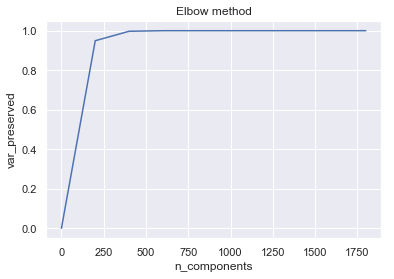

In [44]:
from sklearn.decomposition import TruncatedSVD
n_comp = list(range(0,2000,200))
var_preserved = []
for i in n_comp:
    tsvd = TruncatedSVD(n_components=i)
    tsvd.fit(train_co)
    var_preserved.append(tsvd.explained_variance_ratio_.sum())

sns.set()
plt.plot(n_comp,var_preserved)
plt.ylabel("var_preserved")
plt.xlabel("n_components")
plt.title("Elbow method")
plt.show()

In [45]:
# 250 components preserve almost all of the variance
tsvd_mat = TruncatedSVD(n_components=250).fit_transform(train_co)

Matrix standardization

In [94]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
tsvd_mat = std.fit_transform(tsvd_mat)

###  W2V calculation using truncated matrix with n_components = 250

**1. Project Title**

In [95]:
# for train data
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train["project_title"].values): # for each review/sentence
    vector = np.zeros(250) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in feature_dict:
            vector += tsvd_mat[feature_dict[word]]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)
print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

# for test data
test_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test["project_title"].values): # for each review/sentence
    vector = np.zeros(250) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in feature_dict:
            vector += tsvd_mat[feature_dict[word]]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_avg_w2v_vectors.append(vector)
print(len(test_avg_w2v_vectors))
print(len(test_avg_w2v_vectors[0]))

# for val data
val_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_val["project_title"].values): # for each review/sentence
    vector = np.zeros(250) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in feature_dict:
            vector += tsvd_mat[feature_dict[word]]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    val_avg_w2v_vectors.append(vector)
print(len(val_avg_w2v_vectors))
print(len(val_avg_w2v_vectors[0]))


100%|████████████████████████████████████████████████████████████████████████| 10050/10050 [00:00<00:00, 169886.53it/s]


10050
250


100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 184689.74it/s]


5000
250


100%|██████████████████████████████████████████████████████████████████████████| 4950/4950 [00:00<00:00, 149592.58it/s]


4950
250


**2. Project Essay**

In [96]:
# for train data
essay_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train["essay"].values): # for each review/sentence
    vector = np.zeros(250) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in feature_dict:
            vector += tsvd_mat[feature_dict[word]]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    essay_avg_w2v_vectors.append(vector)
print(len(essay_avg_w2v_vectors))
print(len(essay_avg_w2v_vectors[0]))

# for test data
test_essay_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test["essay"].values): # for each review/sentence
    vector = np.zeros(250) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in feature_dict:
            vector += tsvd_mat[feature_dict[word]]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_essay_avg_w2v_vectors.append(vector)
print(len(test_essay_avg_w2v_vectors))
print(len(test_essay_avg_w2v_vectors[0]))

# for val data
val_essay_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_val["essay"].values): # for each review/sentence
    vector = np.zeros(250) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in feature_dict:
            vector += tsvd_mat[feature_dict[word]]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    val_essay_avg_w2v_vectors.append(vector)
print(len(val_essay_avg_w2v_vectors))
print(len(val_essay_avg_w2v_vectors[0]))


100%|█████████████████████████████████████████████████████████████████████████| 10050/10050 [00:00<00:00, 21048.98it/s]


10050
250


100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 19103.85it/s]


5000
250


100%|███████████████████████████████████████████████████████████████████████████| 4950/4950 [00:00<00:00, 18143.55it/s]


4950
250


## Set

In [97]:
title_len = np.array(X_train["title_len"].values)
title_len = np.expand_dims(title_len,axis=1)
print(title_len.shape)

test_title_len = np.array(X_test["title_len"].values)
test_title_len = np.expand_dims(test_title_len,axis=1)
print(test_title_len.shape)

val_title_len = np.array(X_val["title_len"].values)
val_title_len = np.expand_dims(val_title_len,axis=1)
print(val_title_len.shape)

(10050, 1)
(5000, 1)
(4950, 1)


In [98]:
# concatanating all the features
from scipy.sparse import hstack

set_ = hstack((categories_one_hot,sub_categories_one_hot,prefix_one_hot,grade_one_hot,state_one_hot,price_standardized,quantity_standardized,number_ppp_standardized,title_len,avg_w2v_vectors,essay_avg_w2v_vectors))
set_v = hstack((val_categories_one_hot,val_sub_categories_one_hot,val_prefix_one_hot,val_grade_one_hot,val_state_one_hot,val_price_standardized,val_quantity_standardized,val_number_ppp_standardized,val_title_len,val_avg_w2v_vectors,val_essay_avg_w2v_vectors))
set_t = hstack((test_categories_one_hot,test_sub_categories_one_hot,test_prefix_one_hot,test_grade_one_hot,test_state_one_hot,test_price_standardized,test_quantity_standardized,test_number_ppp_standardized,test_title_len,test_avg_w2v_vectors,test_essay_avg_w2v_vectors))


In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier

n_estimators = [5, 10, 50, 100, 200]
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]

def Plot_heatmap(mean_score,name):
    """
    This function plots heatmap.
    """
    df = pd.DataFrame(mean_score,index = n_estimators,columns = max_depth)
    sns.heatmap(df,annot = True)
    plt.ylabel("n_estimators")
    plt.xlabel("max_depth")
    plt.title(name)
    plt.show()

In [101]:
def cf_matrix(cm,msg):
  """
  This function is to plot confusion matrix.
  
  """
  sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel("Actual Class")
  plt.xlabel("Predicted Class")
  plt.title("Confusion Matrix for {}".format(msg))

In [102]:
train_auc = []
cv_auc = []

n_estimators = [5, 10, 50, 100, 200]
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for i in n_estimators:
    train_temp = []
    cv_temp = []
    for j in max_depth:
        xgb = XGBClassifier(max_depth=j,n_estimators=i)
        xgb.fit(set_,y_train)

        y_train_pred = xgb.predict(set_)  
        y_cv_pred = xgb.predict(set_v)

  
        train_temp.append(roc_auc_score(y_train,y_train_pred))
        cv_temp.append(roc_auc_score(y_val, y_cv_pred))
    print("Completed = {}".format(i))
    train_auc.append(train_temp)
    cv_auc.append(cv_temp)

Completed = 5
Completed = 10
Completed = 50
Completed = 100
Completed = 200


**Heatmap**

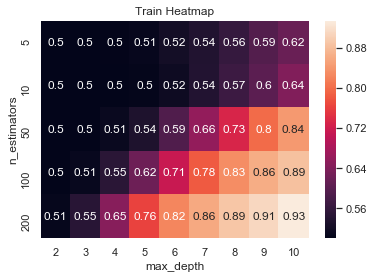

In [103]:
Plot_heatmap(train_auc,"Train Heatmap")

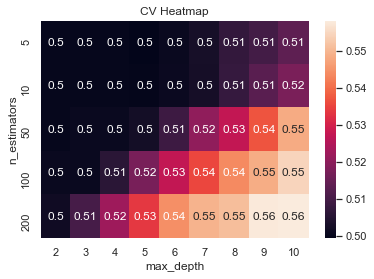

In [104]:
Plot_heatmap(cv_auc,"CV Heatmap")

Best parameter found:
1. n_estimators = 50
2. max_depth = 2

**AUC Plot**

In [171]:
# probabilities calcultion
rf = RandomForestClassifier(n_estimators=50,max_depth=2,class_weight="balanced")
rf.fit(set_,y_train)
y1_predict_prob = rf.predict_proba(set_t)[:,1]
y1_predict_prob_train = rf.predict_proba(set_)[:,1]

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#fpr,tpr 
fpr,tpr,thre = roc_curve(y_test,y1_predict_prob)

# am i doing it right here......?
fpr_train,tpr_train,thre_train = roc_curve(y_train,y1_predict_prob_train)

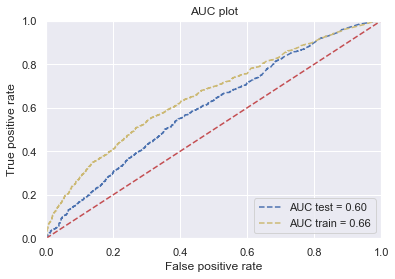

In [172]:
# auc calculation for test data
roc_auc1 = metrics.auc(fpr,tpr)

# auc calculation for train data
roc_auc_train1 = metrics.auc(fpr_train,tpr_train)

# took referance from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.plot(fpr,tpr,"b--",label = 'AUC test = %0.2f'%roc_auc1)
plt.plot(fpr_train,tpr_train,"y--",label = 'AUC train = %0.2f'%roc_auc_train1)
plt.title("AUC plot")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = "lower right")
plt.show()

**Confusion Matrix**

1. Train Data

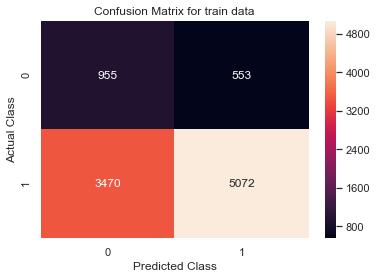

In [173]:
y_train_pred = rf.predict(set_)
cm1 = confusion_matrix(y_train,y_train_pred)
cf_matrix(cm1,"train data")

2. Test Data

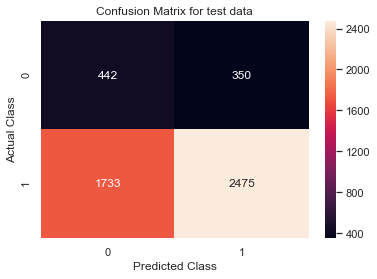

In [174]:
y_test_pred = rf.predict(set_t)
cm1 = confusion_matrix(y_test,y_test_pred)
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
cf_matrix(cm1,"test data")

## Observation:
======================

1. co_occurance matrix Computation is very expensive.
2. Co_occurance matrix is very sparse matrix.
3. It is 99% parse as we considered idf_ values which gaves more importance to the rare words in documents.
4. 250 n_components found to preseve the more than 90% of variance.
5. Gave clear idea regrding w2v's.

## Conclusion:
======================

In [175]:
from prettytable import PrettyTable
summary = PrettyTable()

summary.field_names = ["Set", "Vectorizer", "Hyperparameter","Test","Train"]
summary.add_row(["Set","avg_w2v","n_estimators = 50 , max_depth = 2",0.60,0.68])

print(summary)

+-----+------------+-----------------------------------+------+-------+
| Set | Vectorizer |           Hyperparameter          | Test | Train |
+-----+------------+-----------------------------------+------+-------+
| Set |  avg_w2v   | n_estimators = 50 , max_depth = 2 | 0.6  |  0.68 |
+-----+------------+-----------------------------------+------+-------+
